# **Data 200 - Final Project**


Author:  Aryan Jain

## **Summary Of Contents**

### This Final Project conatins the following sections :

In [19]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [20]:
# Import Data
df = pd.read_csv('survey_results_public.csv')

# Create a new DataFrame with only Python, R, C++ ,and HTML/CSS users
df_langs = df[df['LanguageHaveWorkedWith'].str.contains('Python|R|C\+\+|HTML/CSS', na=False, regex=True)].dropna(subset='Employment')

# Create separate columns for Python, R, C++ , and HTML/CSS
df_langs = df_langs.copy()
df_langs.loc[:, 'Python'] = df_langs['LanguageHaveWorkedWith'].str.contains('Python').astype(int)
df_langs.loc[:, 'R'] = df_langs['LanguageHaveWorkedWith'].str.contains('R').astype(int)
df_langs.loc[:, 'C++'] = df_langs['LanguageHaveWorkedWith'].str.contains('C\+\+').astype(int)
df_langs.loc[:, 'HTML/CSS'] = df_langs['LanguageHaveWorkedWith'].str.contains('HTML/CSS').astype(int)


In [21]:
#df_langs.loc[:,'EmployStatus'] = df_langs['Employment'].str.contains('Employed|employed', case=False).astype(int)
def employ_score(text):
    if text == 'Employed, full-time':
        return 5
    elif text == 'Employed, part-time':
        return 4
    elif text == 'Independent contractor, freelancer, or self-employed':
        return 3
    elif text == 'Not employed, but looking for work':
        return 2
    elif text == 'Student, full-time':
        return 1
    else:
        return 0
        
df_langs.loc[:,'EmployStatus'] = df_langs['Employment'].apply(lambda x: employ_score(x))

In [22]:
df_langs.head()

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly,Python,R,C++,HTML/CSS,EmployStatus
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0,1,0,0,1,5
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0,0,1,0,1,5
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0,0,0,0,1,0
5,6,I agree,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Hobby;Professional development or self-paced l...,Some college/university study without earning ...,Books / Physical media;Colleague;Online Course...,Formal documentation provided by the owner of ...,...,DevOps function;Microservices;Observability to...,Other,Appropriate in length,Neither easy nor difficult,96828.0,0,1,0,1,5
6,7,I agree,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Profe...,Some college/university study without earning ...,Friend or family member;Online Courses or Cert...,NaN,...,Microservices;Automated testing;Continuous int...,"Information Services, IT, Software Development...",Appropriate in length,Easy,135000.0,0,1,0,1,5


In [23]:
np.random.seed(5)
df_langs_model = df_langs.loc[:,['Python', 'C++', 'HTML/CSS','Employment']].dropna()
X = df_langs.loc[:,['Python', 'C++', 'HTML/CSS','']]
y = df_langs['EmployStatus']
X.dtypes
df_langs_model.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

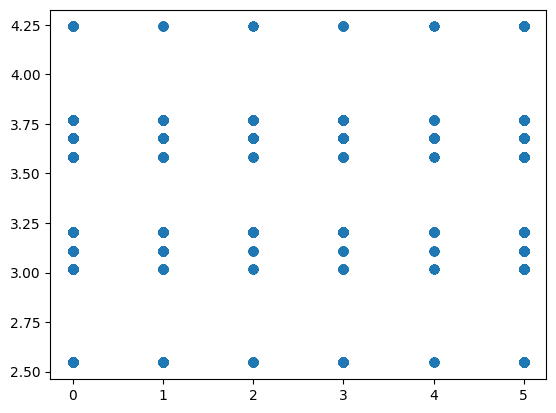

In [24]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

[-0.47349302 -0.65721215 -0.56430822]
4.241218405078895


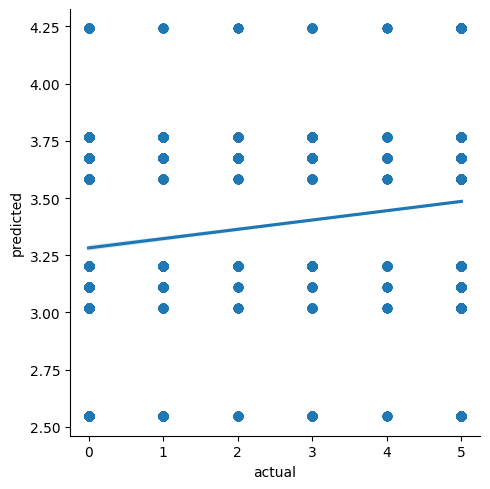

In [28]:
print(linear_model.coef_)
print(linear_model.intercept_)

res_employlang = y_pred - y_test
residual_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'residual': res_employlang}) 
sns.lmplot(x='actual', y='predicted', data=residual_df) # SOLUTION